In [1]:
import os
os.chdir(os.path.expanduser("~/l3_project"))
# for when on NCC to be able to import local packages

In [2]:
import time
import platform

import numpy as np
import einops.einops as einops
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
import torchvision.transforms as transforms
import wandb
import safetensors.torch as st

import datasets.core
import datasets.eurosat

print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [3]:
# sanity check for imports
datasets.core.get_dataset_root()

PosixPath('/home2/jgcw74/datasets')

# EuroSAT Dataset

Using cuda


100%|██████████| 2.07G/2.07G [00:30<00:00, 67.1MB/s]


100%|██████████| 314k/314k [00:00<00:00, 923kB/s] 


100%|██████████| 105k/105k [00:00<00:00, 451kB/s] 


100%|██████████| 104k/104k [00:00<00:00, 450kB/s] 


There are 16200 training samples
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=False)
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[0.0, 0.0], shear=[-0.2, 0.2])
    RandomAffine(degrees=[0.0, 0.0], scale=(1.0, 1.2))
    datasets.core.ClampTransform(min=0.0, max=2750.0)
)


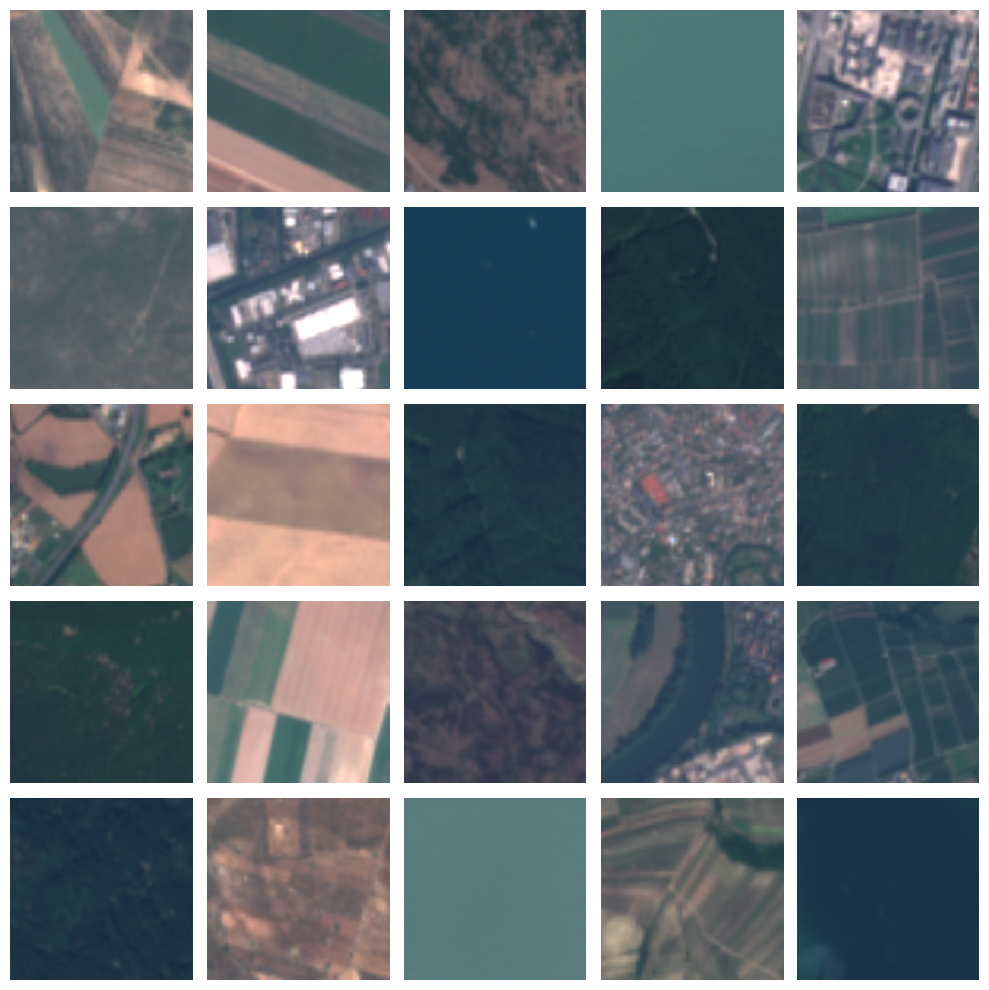

In [5]:
base_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=False),  # Authors rescale images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, shear=0.2),  # Shear with range 0.2
    transforms.RandomAffine(0, scale=(1., 1.2)),  # Zoom in with range 0.2
    datasets.core.ClampTransform(input_min=0., input_max=2750.)  # Authors clamp from 0.-2750 but torchgeo uses 3000
])
wrapped_transforms = datasets.core.tensor_dict_transform_wrapper(base_transforms)

test_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=False),
    datasets.core.ClampTransform(input_min=0., input_max=2750.)
])
wrapped_rescale_clamp_transform = datasets.core.tensor_dict_transform_wrapper(test_transform)

eurosat_train_ds = datasets.eurosat.get_dataset("train", transforms=wrapped_transforms, download=False)
eurosat_test_ds = datasets.eurosat.get_dataset("test", transforms=wrapped_rescale_clamp_transform, download=False)

print(f"There are {len(eurosat_train_ds)} training samples")  # and {len(eurosat_test_ds)} test samples.")
print("Image dimensions and label:", eurosat_train_ds[0]["image"].size(), eurosat_train_ds[0]["label"])

print(base_transforms)

# Display 25 random images from the dataset without border
np.random.seed(42)
random_indices = np.random.choice(len(eurosat_train_ds), size=25, replace=False)
plt.figure(figsize=(10, 10), tight_layout=True)
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(einops.rearrange(eurosat_train_ds[idx]["image"], "c h w -> h w c"))
    plt.axis("off")

## Basic CNN

In [5]:
class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # channels numbers for each layer are not specified by the authors
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # 3, 224, 224 -> 32, 224, 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), # 32, 224, 224 -> 32, 111, 111
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 32, 111, 111  -> 64, 111, 111
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), # 64, 111, 111 -> 64, 54, 54
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # 64, 54, 54 -> 128, 54, 54
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), # 128, 54, 54 -> 128, 26, 26
        )
        self.fc = nn.Linear(128 * 26 * 26, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = einops.rearrange(out, 'b c h w -> b (c h w)')
        out = self.fc(out)
        return out

In [6]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# num_workers=0 is used to avoid a bug in the DataLoader when trying to pickle functions on windows
# see https://discuss.pytorch.org/t/cant-pickle-local-object-dataloader-init-locals-lambda/31857/31
train_dataloader = torch.utils.data.DataLoader(eurosat_train_ds, batch_size=16, num_workers=0, shuffle=True)
testing_dataloader = torch.utils.data.DataLoader(eurosat_test_ds, batch_size=32, num_workers=0, shuffle=True)
test_iterator = iter(cycle(testing_dataloader))

### Training

In [7]:
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
decay = 1e-6
momentum=0.9
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=momentum, nesterov=True)

In [8]:
from pathlib import Path
import json

env_file = Path.cwd() / "env.json"
env_settings = json.load(env_file.open("r"))
wandb_api_key = env_settings["wandb_api_key"]

In [9]:
# !wandb login $wandb_api_key

#### During training testing (and `wandb` logging) function

In [39]:
def during_training_test_step(model_to_test, eval_criterion, test_data_iterator, train_loss_arr, train_acc_arr):
    model_to_test.eval()
    with torch.no_grad():
        print(f"Epoch {epoch:03} - Batch num {i:05}")
        testing_loss_arr = np.zeros(0)
        testing_acc_arr = np.zeros(0)
        for _ in range(20):  # iterate over 20 batches
            test_data = next(test_data_iterator)
            test_images = test_data["image"].to(device)
            test_labels: torch.Tensor = test_data["label"].to(device)

            test_predictions = model_to_test(test_images)

            test_loss = eval_criterion(test_predictions, test_labels)
            testing_loss_arr = np.append(testing_loss_arr, test_loss.item())

            test_accuracy = (test_predictions.argmax(dim=1) == test_labels).float().mean().item()
            testing_acc_arr = np.append(testing_acc_arr, test_accuracy)

        wandb.log({
            "overall_step": epoch * len(train_dataloader) + i,
            "training/loss": train_loss_arr.mean(),
            "training/accuracy": train_acc_arr.mean(),
            "testing/loss": testing_loss_arr.mean(),
            "testing/accuracy": testing_acc_arr.mean()
        })
        print(f"Training loss: {train_loss_arr.mean():.2f}, Training accuracy: {train_acc_arr.mean():.2f}")
        print(f"Testing loss: {testing_loss_arr.mean():.2f}, Testing accuracy: {testing_acc_arr.mean():.2f}")

        train_loss_arr = np.zeros(0)
        train_acc_arr = np.zeros(0)

#### Training Function

In [57]:
def train_step(model_to_train, input_img, targets: torch.Tensor, train_criterion, model_optimiser, train_loss_arr, train_acc_arr, test_data_iterator, step_num):
    preds = model_to_train(input_img)

    loss = train_criterion(preds, targets)
    train_loss_arr = np.append(train_loss_arr, loss.item())

    acc = (preds.argmax(dim=1) == targets).float().mean().item()
    train_acc_arr = np.append(train_acc_arr, acc)

    model_optimiser.zero_grad()
    loss.backward()
    model_optimiser.step()

    if step_num % 200 == 0:
        during_training_test_step(model_to_train, train_criterion, test_data_iterator, train_loss_arr, train_acc_arr)

### Actual Training Loop

In [ ]:
# todo: reload from state to resume training
num_epochs = 120

wandb.init(
    project="basic_eurosat_classification_lit_replication",
    name="SundayFullRun",
    notes="First attempted full run with weight saving and only one CPU thread.",
    config={
        "transforms": repr(base_transforms),
        "model_architecture": repr(model),
        "criterion": criterion.__class__.__name__,
        "optimiser_info": {
            "name": optimiser.__class__.__name__,
            "learning_rate": learning_rate,
            "decay": decay,
            "momentum": momentum
        },
        "dataset": "EuroSAT",
        "epochs": num_epochs,
        "start_time": time.asctime()
    }
)

training_loss_arr = np.zeros(0)
training_acc_arr = np.zeros(0)

for epoch in range(num_epochs):
    print(f"Epoch {epoch:03}")
    for i, data in enumerate(train_dataloader):
        model.train()
        images = data["image"].to(device)
        labels: torch.Tensor = data["label"].to(device)
        train_step(model, images, labels, criterion, optimiser, training_loss_arr, training_acc_arr, test_iterator, i)
    
    if epoch != 0 and epoch % 20 == 0:  
        st.save_model(model, f"checkpoints/basic_cnn_eurosat_epoch_{epoch:03}.safetensors", metadata={"epoch": str(epoch)})
        print(f"Model saved at epoch {epoch:03}.")

In [10]:
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tametnt (tametnt-durham-university). Use `wandb login --relogin` to force relogin


Epoch 000
Epoch 000 - Batch num 00000
Training loss: 2.30, Training accuracy: 0.12
Testing loss: 2.30, Testing accuracy: 0.09
Epoch 000 - Batch num 00200
Training loss: 1.95, Training accuracy: 0.24
Testing loss: 1.79, Testing accuracy: 0.29
Epoch 000 - Batch num 00400
Training loss: 1.59, Training accuracy: 0.38
Testing loss: 1.54, Testing accuracy: 0.40
Epoch 000 - Batch num 00600
Training loss: 1.48, Training accuracy: 0.46
Testing loss: 1.34, Testing accuracy: 0.53
Epoch 000 - Batch num 00800
Training loss: 1.36, Training accuracy: 0.50
Testing loss: 1.50, Testing accuracy: 0.40
Epoch 000 - Batch num 01000
Training loss: 1.25, Training accuracy: 0.55
Testing loss: 1.52, Testing accuracy: 0.43
Epoch 001
Epoch 001 - Batch num 00000
Training loss: 1.44, Training accuracy: 0.48
Testing loss: 1.16, Testing accuracy: 0.57
Epoch 001 - Batch num 00200
Training loss: 1.17, Training accuracy: 0.58
Testing loss: 1.15, Testing accuracy: 0.57
Epoch 001 - Batch num 00400
Training loss: 1.09, Tra

KeyboardInterrupt: 

In [11]:
wandb.finish()  # just in case

In [12]:
st.save_model(model, f"checkpoints/basic_cnn_eurosat_epoch_036.safetensors", metadata={"epoch": str(36)})

### Evaluation

In [64]:
eval_set_ds = datasets.eurosat.get_dataset("val", transforms=wrapped_rescale_clamp_transform)
eval_dataloader = torch.utils.data.DataLoader(eval_set_ds, batch_size=64, num_workers=0, shuffle=False)

#### Evaluate using validation set function

In [73]:
def evaluate_model(model_to_eval, evaluation_dataloader):
    model_to_eval.eval()
    
    with torch.no_grad():
        batch_accuracy = np.zeros(0)
        
        all_labels = np.zeros(0)
        all_predictions = np.zeros(0)
        
        for i, data in enumerate(evaluation_dataloader):
            print(f"Assessing batch {i:05}", end="\r")
            images = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model_to_eval(images)
            predictions = outputs.argmax(dim=1, keepdim=True)
    
            all_labels = np.append(all_labels, labels.cpu().numpy())
            all_predictions = np.append(all_predictions, predictions.cpu().numpy())
            
            batch_accuracy = np.append(batch_accuracy, predictions.data.eq(labels.view_as(predictions)).float().mean().item())
    
        print(f"Accuracy of the model on the {len(all_labels)} evaluation images: {batch_accuracy.mean():.5f}")
    
    return all_labels, all_predictions

In [ ]:
eval_labels, eval_predictions = evaluate_model(model, eval_dataloader)

#### Confusion Matrix

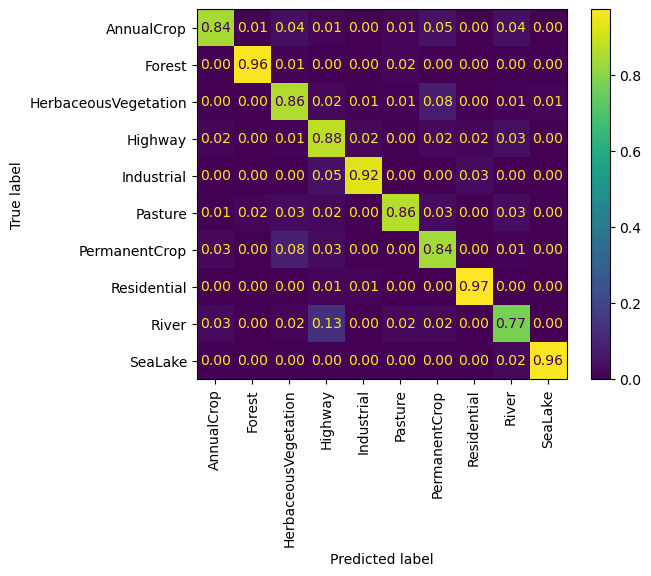

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(eval_labels, eval_predictions,
                                        normalize="true", values_format=".2f",
                                        display_labels=eval_set_ds.classes, xticks_rotation="vertical")

In [68]:
def show_sample_of_incorrect(idx_where_wrong, dataset, dataset_classes):
    np.random.seed(69)
    random_wrong_idxs = np.random.choice(idx_where_wrong, size=25, replace=False)
    fig = plt.figure(figsize=(10, 10), tight_layout=True)
    for i, idx in enumerate(random_wrong_idxs):
        ax = plt.subplot(5, 5, i + 1)
        plt.title(f"'{dataset_classes[int(eval_predictions[idx])]}'\n({dataset_classes[int(eval_labels[idx])]})")
        plt.imshow(einops.rearrange(dataset[idx]["image"], "c h w -> h w c"))
        plt.axis("off")
        
    return fig

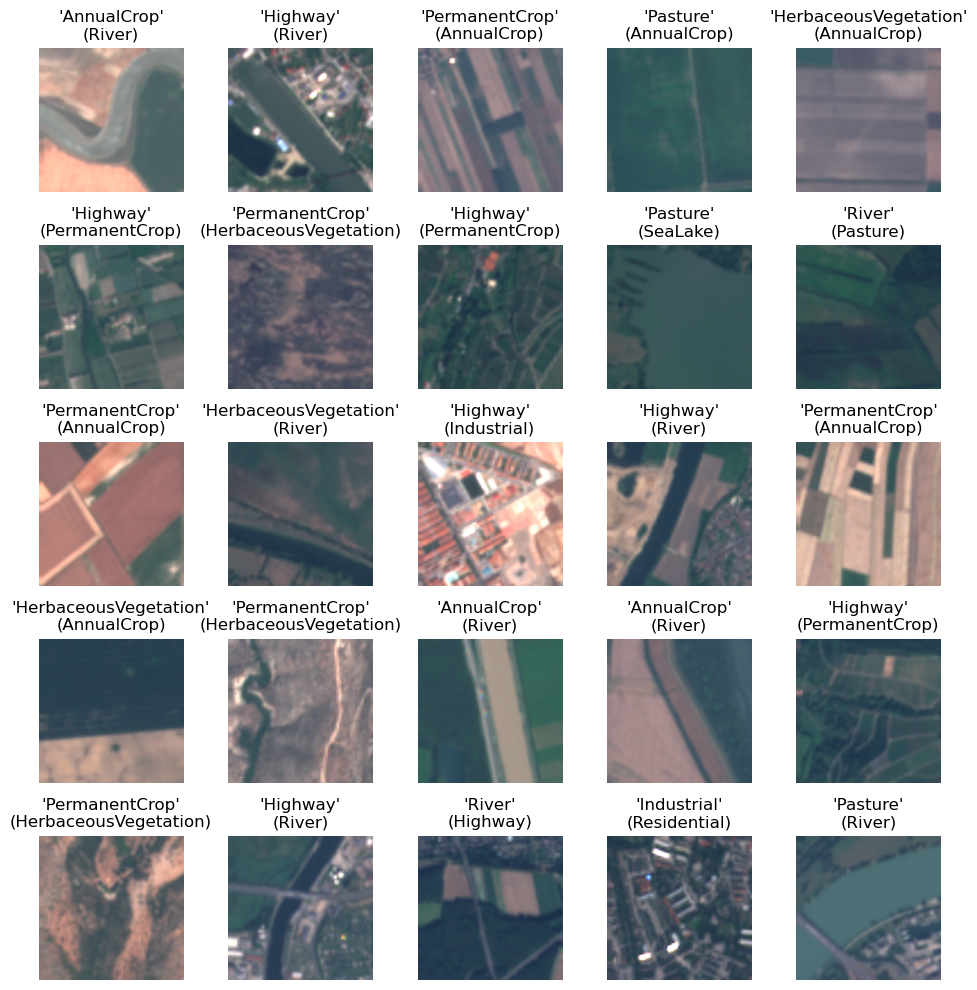

In [32]:
incorrect_idxs = np.where(eval_labels != eval_predictions)[0]

show_sample_of_incorrect(incorrect_idxs, eval_set_ds, eval_set_ds.classes)

In [33]:
eurosat_test_ds.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

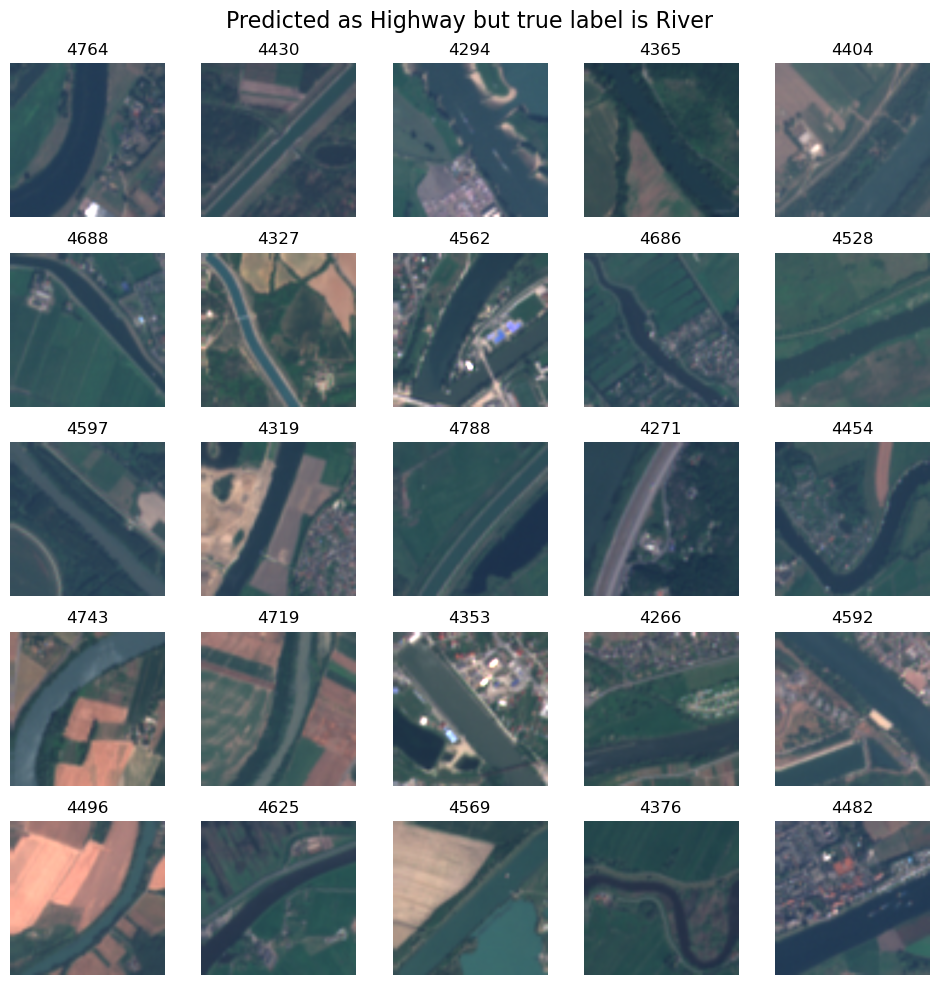

In [39]:
# get the indices where highway was predicted but true label was river
incorrect_idxs = np.where((eval_predictions == 3.0) & (eval_labels == 8.0))[0]

f = show_sample_of_incorrect(incorrect_idxs, eval_set_ds, eval_set_ds.classes)
f.suptitle(f"Predicted as {eval_set_ds.classes[3]} but true label is {eval_set_ds.classes[8]}", fontsize=16)

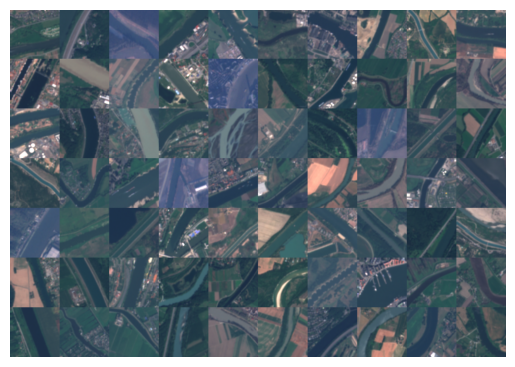

In [52]:
concat_images = torch.stack([eval_set_ds[idx]["image"] for idx in incorrect_idxs])
plt.axis("off")
plt.imshow(einops.rearrange(concat_images[:-1], "(rows cols) c h w -> (rows h) (cols w) c", rows=7, cols=10))

## Fine-tuning pretrained models

In [13]:
import torchvision

### ResNet50

In [35]:
class ResNet50FineTuned(nn.Module):
    def __init__(self, num_classes=len(eurosat_test_ds.classes)):
        super().__init__()
        # load with pre-trained weights
        self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
    
    def freeze_layers(self, from_input_up_to: int):
        """
        Freeze layers (requires_grad = False) up to a certain depth from the input layer.
        :param from_input_up_to: Depth exclusive to freeze layers up to
        :return: 
        """
        for depth_from_input, layer in enumerate(self.model.children()):
            if depth_from_input < from_input_up_to:
                for param in layer.parameters():
                    param.requires_grad = False
                    
    def unfreeze_layers(self):
        """
        Unfreeze all layers in the model.
        :return: 
        """
        for param in self.parameters():
            param.requires_grad = True
            
    def extra_repr(self):
        """
        Add additional detail on number of frozen layers.
        :return: 
        """
        num_frozen = 0
        frozen_layers = []
        for layer in self.model.children():
            for param in layer.parameters():
                if not param.requires_grad:
                    num_frozen += 1
                    frozen_layers.append(layer)
                    break

        return f"> {num_frozen} layers frozen: {', '.join([layer.__class__.__name__ for layer in frozen_layers])} <"

resnet = ResNet50FineTuned().to(device)

### Data loading

In [59]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# num_workers=0 is used to avoid a bug in the DataLoader when trying to pickle functions on windows
# see https://discuss.pytorch.org/t/cant-pickle-local-object-dataloader-init-locals-lambda/31857/31
train_dataloader = torch.utils.data.DataLoader(eurosat_train_ds, batch_size=16, num_workers=0, shuffle=True)
testing_dataloader = torch.utils.data.DataLoader(eurosat_test_ds, batch_size=32, num_workers=0, shuffle=True)
test_iterator = iter(cycle(testing_dataloader))

### Training

#### Final Layer Fine-tuning

In [45]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
decay = 1e-6
momentum=0.9

In [46]:
# freeze all layers except the last one initially
resnet.freeze_layers(len(list(resnet.model.children())) - 1)
print(resnet)

ResNet50FineTuned(
  > 6 layers frozen: Conv2d, BatchNorm2d, Sequential, Sequential, Sequential, Sequential <
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [47]:
parameters_to_optimise = filter(lambda p: p.requires_grad, resnet.parameters())
optimiser = torch.optim.SGD(parameters_to_optimise, lr=learning_rate, weight_decay=decay, momentum=momentum, nesterov=True)

In [48]:
num_epochs = 120

wandb.init(
    project="basic_eurosat_classification_lit_replication",
    name="Fine-tuning ResNet50",
    notes="Fine-tuning ResNet50 on EuroSAT dataset.",
    config={
        "transforms": repr(base_transforms),
        "model_architecture": repr(resnet),
        "criterion": criterion.__class__.__name__,
        "optimiser_info": {
            "name": optimiser.__class__.__name__,
            "learning_rate": learning_rate,
            "decay": decay,
            "momentum": momentum
        },
        "dataset": "EuroSAT",
        "epochs": num_epochs,
        "start_time": time.asctime()
    }
)

training_loss_arr = np.zeros(0)
training_acc_arr = np.zeros(0)

for epoch in range(num_epochs):
    print(f"Epoch {epoch:03}")
    for i, data in enumerate(train_dataloader):
        resnet.train()
        images = data["image"].to(device)
        labels: torch.Tensor = data["label"].to(device)
        train_step(resnet, images, labels, criterion, optimiser, training_loss_arr, training_acc_arr, test_iterator, i)

    if epoch != 0 and epoch % 20 == 0:
        st.save_model(resnet, f"checkpoints/resnet50_eurosat_epoch_{epoch:03}.safetensors", metadata={"epoch": str(epoch)})
        print(f"Model saved at epoch {epoch:03}.")

Epoch 000
Epoch 000 - Batch num 00000
Training loss: 2.42, Training accuracy: 0.06
Testing loss: 2.35, Testing accuracy: 0.12
Epoch 000 - Batch num 00200
Training loss: 0.78, Training accuracy: 0.75
Testing loss: 0.32, Testing accuracy: 0.90
Epoch 000 - Batch num 00400
Training loss: 0.28, Training accuracy: 0.94
Testing loss: 0.36, Testing accuracy: 0.87
Epoch 000 - Batch num 00600
Training loss: 0.42, Training accuracy: 0.88
Testing loss: 0.39, Testing accuracy: 0.88
Epoch 000 - Batch num 00800
Training loss: 1.01, Training accuracy: 0.75
Testing loss: 0.35, Testing accuracy: 0.90
Epoch 000 - Batch num 01000
Training loss: 0.06, Training accuracy: 1.00
Testing loss: 0.22, Testing accuracy: 0.92
Epoch 001
Epoch 001 - Batch num 00000
Training loss: 0.51, Training accuracy: 0.81
Testing loss: 0.24, Testing accuracy: 0.92
Epoch 001 - Batch num 00200
Training loss: 0.80, Training accuracy: 0.81
Testing loss: 0.36, Testing accuracy: 0.89
Epoch 001 - Batch num 00400
Training loss: 0.25, Tra

KeyboardInterrupt: 

In [49]:
st.save_model(resnet, f"checkpoints/resnet50_eurosat_one_layer_finetune.safetensors", metadata={"epoch": str(2)})

#### Full Model Fine-tuning

In [50]:
resnet.unfreeze_layers()
resnet

ResNet50FineTuned(
  > 0 layers frozen:  <
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

In [60]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005  # middle ground between 0.01 and 0.0001 range given by authors
decay = 1e-6
momentum = 0.9
optimiser = torch.optim.SGD(resnet.parameters(), lr=learning_rate, weight_decay=decay, momentum=momentum, nesterov=True)

In [61]:
training_loss_arr = np.zeros(0)
training_acc_arr = np.zeros(0)

for epoch in range(3, num_epochs):
    print(f"New Epoch {epoch:03}")
    for i, data in enumerate(train_dataloader):
        resnet.train()
        images = data["image"].to(device)
        labels: torch.Tensor = data["label"].to(device)
        train_step(resnet, images, labels, criterion, optimiser, training_loss_arr, training_acc_arr, test_iterator, i)

New Epoch 003
Epoch 003 - Batch num 00000
Training loss: 0.83, Training accuracy: 0.81
Testing loss: 0.71, Testing accuracy: 0.85
Epoch 003 - Batch num 00200
Training loss: 0.25, Training accuracy: 0.94
Testing loss: 0.18, Testing accuracy: 0.95
Epoch 003 - Batch num 00400
Training loss: 0.63, Training accuracy: 0.81
Testing loss: 0.14, Testing accuracy: 0.96
Epoch 003 - Batch num 00600
Training loss: 0.61, Training accuracy: 0.81
Testing loss: 0.14, Testing accuracy: 0.95
Epoch 003 - Batch num 00800
Training loss: 0.28, Training accuracy: 0.94
Testing loss: 0.08, Testing accuracy: 0.97
Epoch 003 - Batch num 01000
Training loss: 0.20, Training accuracy: 0.88
Testing loss: 0.10, Testing accuracy: 0.97
New Epoch 004
Epoch 004 - Batch num 00000
Training loss: 0.06, Training accuracy: 1.00
Testing loss: 0.10, Testing accuracy: 0.96
Epoch 004 - Batch num 00200
Training loss: 0.44, Training accuracy: 0.88
Testing loss: 0.13, Testing accuracy: 0.96
Epoch 004 - Batch num 00400
Training loss: 0

KeyboardInterrupt: 

In [62]:
st.save_model(resnet, f"checkpoints/resnet50_eurosat_full_finetuned.safetensors", metadata={"epoch": str(7)})

In [63]:
wandb.finish()

### Evaluation

In [67]:
eval_labels, eval_predictions = evaluate_model(resnet, eval_dataloader)

Accuracy of the model on the 5400 test images: 0.98


In [74]:
np.mean(eval_labels == eval_predictions)

0.9803703703703703

#### Confusion Matrix

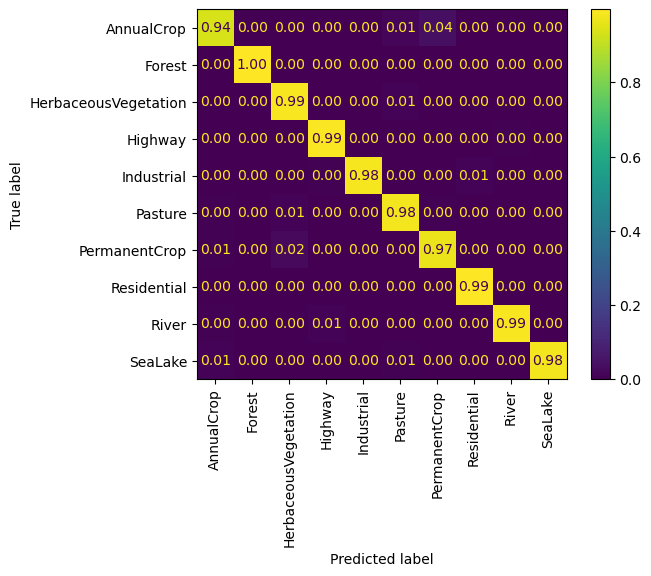

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(eval_labels, eval_predictions,
                                        normalize="true", values_format=".2f",
                                        display_labels=eval_set_ds.classes, xticks_rotation="vertical")

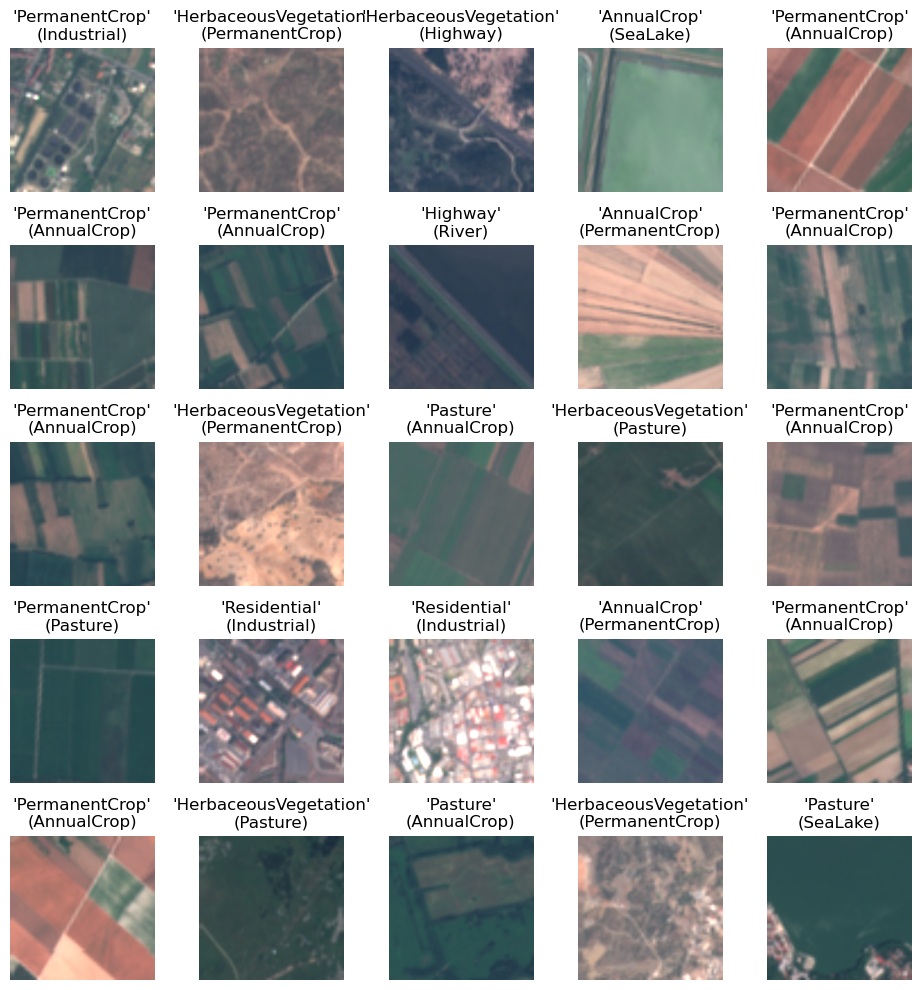

In [72]:
incorrect_idxs = np.where(eval_labels != eval_predictions)[0]

_ = show_sample_of_incorrect(incorrect_idxs, eval_set_ds, eval_set_ds.classes)